In [1]:
# Import necessary libraries

import time
import random
import numpy as np
import copy
import json
from collections import Counter
from typing import Dict, Any, List, Tuple

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp
from baselines import logger

from stable_baselines3 import DQN

# Import Yawning Titan specific modules
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.game_modes.game_mode import GameMode
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network
from yawning_titan.envs.generic.core import reward_functions
from yawning_titan.envs.generic.helpers.eval_printout import EvalPrintout
from yawning_titan.envs.generic.helpers.graph2plot import CustomEnvGraph

# Import Reward Machine related modules
from reward_machines.reward_machine import RewardMachine
from reward_machines.rm_environment import RewardMachineEnv, RewardMachineWrapper
from reward_machines.reward_functions import ConstantRewardFunction
from reward_machines.reward_machine_utils import evaluate_dnf

In [2]:
# Load the game mode from a YAML file
game_mode = GameMode()
game_mode = game_mode.create_from_yaml(yaml='game_mode_balanced.yaml', legacy=False, infer_legacy=True)
print(game_mode.game_rules.max_steps.value)

# Create a network representation
network = Network()

# Define network nodes and their positions

# External layer
router_1 = Node("Boundary router packet filter")
router_1.node_position = [0, 600]
network.add_node(router_1)

switch_1 = Node("External switch")
switch_1.node_position = [0, 500]
network.add_node(switch_1)

network_ids_1 = Node("Network IDS (DMZ)")
network_ids_1.node_position = [-200, 500]
network.add_node(network_ids_1)

dns_server_external = Node("DNS server esterno")
dns_server_external.node_position = [200, 500]
network.add_node(dns_server_external)

# DMZ layer
server_1 = Node("Main Firewall/VPN server/NAT")
server_1.node_position = [-100, 400]
network.add_node(server_1)

server_2 = Node("External Web Server/Host IDS")
server_2.node_position = [100, 400]
network.add_node(server_2)

switch_2 = Node("Internal Switch (DMZ)")
switch_2.node_position = [0, 300]
network.add_node(switch_2)

network_ids_2 = Node("Network IDS (DMZ Internal)")
network_ids_2.node_position = [-200, 300]
network.add_node(network_ids_2)

# Internal layer
internal_firewall = Node("Internal Firewall")
internal_firewall.node_position = [0, 200]
network.add_node(internal_firewall)

server_3 = Node("Database Server")
server_3.node_position = [200, 200]
network.add_node(server_3)

email_server = Node("Email Server/Host IDS")
email_server.node_position = [-200, 200]
network.add_node(email_server)

dns_server_internal = Node("DNS server interno")
dns_server_internal.node_position = [400, 200]
network.add_node(dns_server_internal)

web_proxy = Node("Web proxy server")
web_proxy.node_position = [-400, 200]
network.add_node(web_proxy)

switch_3 = Node("Internal Switch")
switch_3.node_position = [0, 100]
network.add_node(switch_3)

network_ids_3 = Node("Network IDS Internal")
network_ids_3.node_position = [-200, 100]
network.add_node(network_ids_3)

# Subnet layer
subnet1_router = Node("Router Subnet 1")
subnet1_router.node_position = [-300, 0]
network.add_node(subnet1_router)

subnet2_router = Node("Router Subnet 2")
subnet2_router.node_position = [-100, 0]
network.add_node(subnet2_router)

subnet3_router = Node("Router Subnet 3")
subnet3_router.node_position = [100, 0]
network.add_node(subnet3_router)

subnet4_router = Node("Router Subnet 4")
subnet4_router.node_position = [300, 0]
network.add_node(subnet4_router)

# Client/Server layer
client1_management = Node("Client1 Management")
client1_management.node_position = [-300, -100]
network.add_node(client1_management)

client1_hr = Node("Client1 HR")
client1_hr.node_position = [-100, -100]
network.add_node(client1_hr)

client1_it = Node("Client1 IT")
client1_it.node_position = [100, -100]
network.add_node(client1_it)

server_backup = Node("Server backup")
server_backup.node_position = [300, -100]
network.add_node(server_backup)

# Add edges to connect nodes
network.add_edge(router_1, switch_1)
network.add_edge(switch_1, server_1)
network.add_edge(switch_1, server_2)
network.add_edge(switch_1, network_ids_1)
network.add_edge(switch_1, dns_server_external)
network.add_edge(server_1, switch_2)
network.add_edge(switch_2, server_3)
network.add_edge(switch_2, internal_firewall)
network.add_edge(switch_2, email_server)
network.add_edge(switch_2, dns_server_internal)
network.add_edge(switch_2, web_proxy)
network.add_edge(switch_2, network_ids_2)
network.add_edge(internal_firewall, switch_3)
network.add_edge(switch_3, network_ids_3)
network.add_edge(switch_3, subnet1_router)
network.add_edge(switch_3, subnet2_router)
network.add_edge(switch_3, subnet3_router)
network.add_edge(switch_3, subnet4_router)
network.add_edge(subnet1_router, client1_management)
network.add_edge(subnet2_router, client1_hr)
network.add_edge(subnet3_router, client1_it)
network.add_edge(subnet4_router, server_backup)


# Set entry and high-value nodes
router_1.entry_node = True
server_3.high_value_node = True
server_backup.high_value_node = True


# Display the network details
network.show(verbose=True)

300
UUID                                  Name                           High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  -----------------------------  -----------------  ------------  ---------------  ----------------
72a0eaea-f5b5-4bdd-836c-96e2283256a3  Boundary router packet filter  False              True                     0.01  0.00, 600.00
854dfd00-2417-4323-8193-d7a697d4514a  External switch                False              False                    0.01  0.00, 500.00
a66e91ca-96f1-4316-8bf3-487e0a255f0b  Network IDS (DMZ)              False              False                    0.01  -200.00, 500.00
8ac02c2f-f9b9-47b8-a08b-4fc442b94d2b  DNS server esterno             False              False                    0.01  200.00, 500.00
a4f800ec-2e17-4a2a-b4a9-858af5d49196  Main Firewall/VPN server/NAT   False              False                    0.01  -100.00, 400.00
4ea43e90-2407-45f5-9062-c3956492045b  External Web Server/

In [3]:
# Create NetworkInterface, RedInterface, and BlueInterface objects
network_interface = NetworkInterface(game_mode=game_mode, network=network)
red = RedInterface(network_interface)
blue = BlueInterface(network_interface)

In [4]:
YTenv = GenericNetworkEnv(
    red,
    blue,
    network_interface,
    show_metrics_every=10
)

In [5]:
# Create and train PPO agent 
agent = PPO(PPOMlp, YTenv, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
agent.learn(total_timesteps=100000)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -3.28e+03 |
| time/              |           |
|    fps             | 722       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -3.26e+03    |
| time/                   |              |
|    fps                  | 628          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009326257 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.00196      |
|    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -3e+03      |
| time/                   |             |
|    fps                  | 563         |
|    iterations           | 11          |
|    time_elapsed         | 40          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.006850228 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.19       |
|    explained_variance   | -7.75e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 8.32e+03    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 1.67e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -2.33e+03   |
| time/                   |             |
|    fps                  | 555         |
|    iterations           | 21          |
|    time_elapsed         | 77          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.011781075 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.89       |
|    explained_variance   | -1.79e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.19e+03    |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 6.83e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -1.67e+03   |
| time/                   |             |
|    fps                  | 558         |
|    iterations           | 31          |
|    time_elapsed         | 113         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.020852773 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.12       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.48e+03    |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 2.45e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -909         |
| time/                   |              |
|    fps                  | 555          |
|    iterations           | 41           |
|    time_elapsed         | 151          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0034328261 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 640          |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.0033      |
|    value_loss           | 1.21e+03     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

In [7]:
evaluate_policy(agent, YTenv, n_eval_episodes=10)

(-182.4886929532513, 2.544183596439689)

In [8]:
# Use DQN for discrete action spaces
#agent = DQN("MlpPolicy", YTenv, verbose=1)

# Train the agent
#agent.learn(total_timesteps=100000, n_eval_episodes=1)

In [9]:
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt

# Wrap the environment
env = Monitor(YTenv)

# Train the agent
agent = PPO(PPOMlp, env, verbose=1)
agent.learn(total_timesteps=100000)

import numpy as np
from matplotlib.ticker import MaxNLocator

# Supponiamo che questi siano i tuoi dati
rewards = env.get_episode_rewards()



Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -3.57e+03 |
| time/              |           |
|    fps             | 602       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -3.48e+03    |
| time/                   |              |
|    fps                  | 586          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0007859762 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -3.09e+03    |
| time/                   |              |
|    fps                  | 578          |
|    iterations           | 11           |
|    time_elapsed         | 38           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0074811364 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.2         |
|    explained_variance   | -1.67e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.75e+03     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.012       |
|    value_loss           | 1.88e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -2.38e+03   |
| time/                   |             |
|    fps                  | 573         |
|    iterations           | 21          |
|    time_elapsed         | 75          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.013729341 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 2.38e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.64e+03    |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 5.29e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -1.69e+03   |
| time/                   |             |
|    fps                  | 576         |
|    iterations           | 31          |
|    time_elapsed         | 110         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.016613472 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.54       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.12e+03    |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 3.04e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 300        |
|    ep_rew_mean          | -1.39e+03  |
| time/                   |            |
|    fps                  | 581        |
|    iterations           | 41         |
|    time_elapsed         | 144        |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.02035545 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.71      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 1.38e+03   |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.00297   |
|    value_loss           | 2.77e+03   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_m

2024-08-21 16:17:42,749::WARNING::py.warnings::_showwarnmsg::109::/var/folders/q5/dv8731x923b6znxm0mvdfxjw0000gn/T/ipykernel_87331/1106575282.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



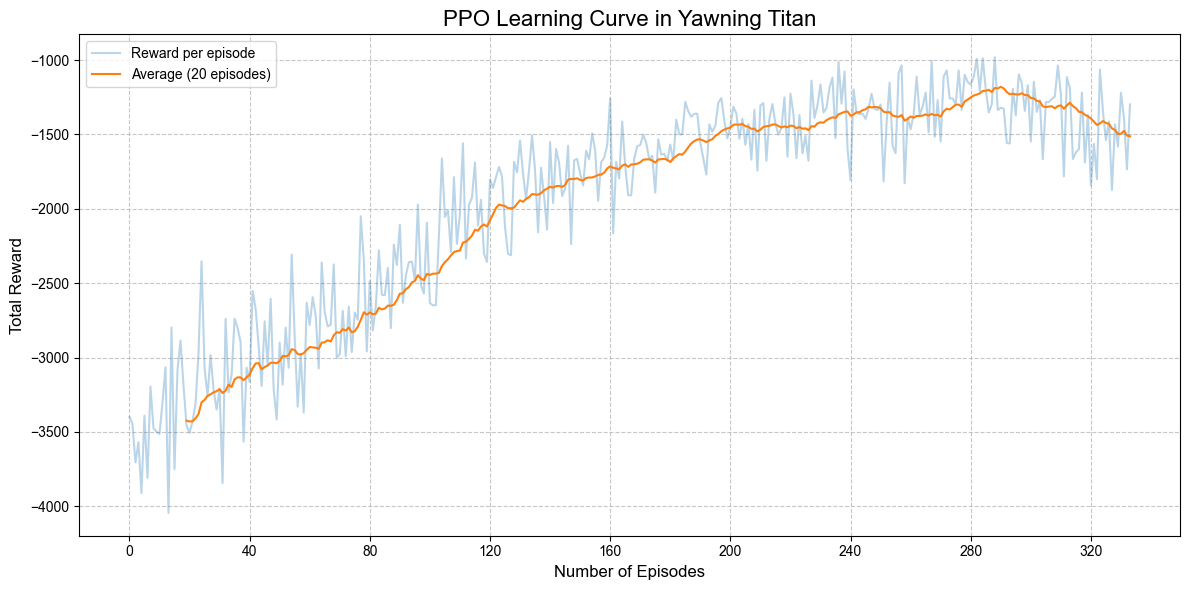

In [10]:
# Calculate the moving average
window_size = 20
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.3, color='#1f77b4', label='Reward per episode')
plt.plot(range(window_size-1, len(rewards)), moving_avg, color='#ff7f0e', label=f'Average ({window_size} episodes)')
plt.title('PPO Learning Curve in Yawning Titan', fontsize=16)
plt.xlabel('Number of Episodes', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.style.use('seaborn')
plt.tight_layout()
plt.show()